In [1]:
# set cwd and solver
import os
import cobra
cobra.Configuration().solver = "gurobi"
os.chdir('C:/Users/prins/GitHub/Human1_RPE-PR') 

In [2]:
# load all models in \cs_mods\July2023 folder by cycling through names
from cobra.io import read_sbml_model    
from pathlib import Path
import pandas as pd

# do not change directory but still go to the folder with the models
folder = Path().cwd() / "cs_mods" / "July2023"
model_list = []
for file in folder.glob("*.xml"):  
    model = read_sbml_model(file)
    model.id = file.stem # remove .xml 
    model.name = file.stem # remove .xml
    model_list.append(model)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-03


No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized


In [3]:
# load old combined RPE_PR models
mod_RPE_PR = read_sbml_model(Path().cwd() / "models" / "mod_RPE_PR.xml")
mod_RPE_PR.id = 'RPE_PR_old'
mod_RPE_PR.name = 'RPE_PR_old'
mod_Human1_Human1 = read_sbml_model(Path().cwd() / "models" /  "mod_Human1_Human1.xml")
mod_Human1_Human1.id = 'RPE_PR_control_old'
mod_Human1_Human1.name = 'RPE_PR_control_old'
mod = read_sbml_model(Path().cwd() / 'models/Human-GEM.xml')
mod.id = 'Human1_old'
mod.name = 'Human1_old'

# add old models to model_list
model_list = model_list + [mod,mod_RPE_PR]

# check out model_list
model_list

[<Model Human-GEM_28062023 at 0x1e0baa954e0>,
 <Model mod_RPE_PRcone_Liang at 0x1e0ffc0aad0>,
 <Model mod_RPE_PRcone_Liang_singlePR at 0x1e08f182740>,
 <Model mod_RPE_PRcone_Liang_singleRPE at 0x1e08f5e41f0>,
 <Model mod_RPE_PRcone_Lukowski at 0x1e09e777940>,
 <Model mod_RPE_PRcone_Lukowski_singlePR at 0x1e0a35d2590>,
 <Model mod_RPE_PRcone_Lukowski_singleRPE at 0x1e0aadd5870>,
 <Model mod_RPE_PRcontrol at 0x1e103f871f0>,
 <Model mod_RPE_PRrod_Liang at 0x1e119173760>,
 <Model mod_RPE_PRrod_Liang_singlePR at 0x1e1603c3130>,
 <Model mod_RPE_PRrod_Liang_singleRPE at 0x1e16268b1c0>,
 <Model mod_RPE_PRrod_Lukowski at 0x1e1667b1a20>,
 <Model mod_RPE_PRrod_Lukowski_singlePR at 0x1e11907c340>,
 <Model mod_RPE_PRrod_Lukowski_singleRPE at 0x1e172113cd0>,
 <Model Human1_old at 0x1e18f0f2320>,
 <Model RPE_PR_old at 0x1e0b3817730>]

In [4]:
# modify models
# load blood exchange bounds

# for all models in the list set objective function (ATP hydrolysis, in PR for combined models)
for m in model_list:
    if 'MAR03964_PR' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964_PR'
    elif 'MAR03964_RPE' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964_RPE'
    elif 'MAR03964' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964'
    else:
        print('no ATP hydrolysis reaction (MAR03964) in model: ' + m.id)

# list combined and single models
combined_models = [m for m in model_list if 'single' not in m.id and 'Human' not in m.id]
single_models = [m for m in model_list if 'single' in m.id]
Human1_models = [m for m in model_list if 'Human' in m.id]

# close PR exchange in combined models and open RPE exchange (efflux)
for m in combined_models:
    for r in [r for r in m.reactions if len(r.products) == 0 ]:           # close all exchange reactions
        r.bounds=(0,0)
    for r in [r for r in m.reactions if len(r.products) == 0 if '_RPE' in r.id]:           # open efflux for RPE exchange reactions
        r.bounds=(0,1000) 

# only allow efflux exchange in single models
for m in single_models:
    for r in [r for r in m.reactions if len(r.products) == 0 ]:           # close all exchange reactions
        r.bounds=(0,1000)

# for Human1 models, open efflux
for m in [m for m in model_list if 'Human' in m.id]:
    for r in [r for r in m.reactions if len(r.products) == 0]:           # open efflux for RPE exchange reactions
        r.bounds=(0,1000)

In [5]:
# set exchange bounds for blood
from src.modify_model import set_exchange_bounds
ex_bounds = {'MAR09048':(-3.51,1000),'MAR09034':(-4.18,1000),'MAR09135':(7.25,1000)}
# MAR09048: oxygen
# MAR09034: glucose
# MAR09135: lactate

results_dict = {}
for m in model_list:
    set_exchange_bounds(m, ex_bounds)
    m.optimize()
    results_dict[m.id] = m.objective.value
df1 = pd.DataFrame(results_dict, index = ['max ATP hydrolysis (pmol/s/mm^2)']).T
df1

,max ATP hydrolysis (pmol/s/mm^2)
Human-GEM_28062023,24.7325
mod_RPE_PRcone_Liang,23.9000
mod_RPE_PRcone_Liang_singlePR,11.1350
mod_RPE_PRcone_Liang_singleRPE,23.9000
mod_RPE_PRcone_Lukowski,24.7325
mod_RPE_PRcone_Lukowski_singlePR,22.2350
mod_RPE_PRcone_Lukowski_singleRPE,23.9000
mod_RPE_PRcontrol,24.7325
mod_RPE_PRrod_Liang,23.9000
mod_RPE_PRrod_Liang_singlePR,13.9100


In [6]:
def create_stepwise_tuples(start,stop,step):
        """
        this function creates a list of tuples with the same start and stop values, but with a stepwise increase in the values
        """
        import numpy as np
        return [(i,i) for i in np.arange(start,stop+step,step)]
from src.modify_model import create_permutation_dicts

glucose_level = 0
bounds_oxygen = create_stepwise_tuples(-8,1,1)
bounds_lactate = create_stepwise_tuples(-4,10,1)
ex_bounds = {'MAR09034':[(glucose_level,glucose_level)],\
                'MAR09048':bounds_oxygen,\
                'MAR09135':bounds_lactate}
ex_labels = {'glucose':[(glucose_level,glucose_level)],\
                'oxygen':bounds_oxygen,\
                'lactate':bounds_lactate}
bounds = create_permutation_dicts(ex_bounds)
labels = create_permutation_dicts(ex_labels)

In [7]:
objective_values ={}
fluxes = {}
for i in range(len(bounds)):
    model   = set_exchange_bounds(model,bounds[i])
    fba     = model.optimize()
    fluxes[str(labels[i])] = fba.fluxes
    objective_values [str(labels[i])]  = fba.objective_value

c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\u

In [8]:
# select model for heatmaps
model = model_list[-5]
model

Name,mod_RPE_PRrod_Lukowski
Memory address,1e1667b1a20
Number of metabolites,10678
Number of reactions,14592
Number of genes,2188
Number of groups,149
Objective expression,1.0*MAR03964_PR - 1.0*MAR03964_PR_reverse_e8402
Compartments,"c_RPE, r_RPE, e_RPE, m_RPE, x_RPE, g_RPE, l_RPE, n_RPE, i_RPE, e_RPE_PR, c_PR, x_PR, m_PR, g_PR, r_PR, l_PR, i_PR"


In [9]:
###############################################################
####### KEEP GLUCOSE CONSTANT, VARY OXYGEN AND LACTATE ########
###############################################################


from src.modify_model import create_permutation_dicts

# create a function to create stepwise tuple lists like the ones above
def create_stepwise_tuples(start,stop,step):
        import numpy as np
        return [(i,i) for i in np.arange(start,stop+step,step)]


# write function to set exchange bounds
def create_bounds_and_labels_glucose_constant(bounds_oxygen, bounds_lactate, glucose_level):
        ex_bounds = {'MAR09034':[(glucose_level,glucose_level)],\
                        'MAR09048':bounds_oxygen,\
                        'MAR09135':bounds_lactate}
        ex_labels = {'glucose':[(glucose_level,glucose_level)],\
                        'oxygen':bounds_oxygen,\
                        'lactate':bounds_lactate}
        bounds = create_permutation_dicts(ex_bounds)
        labels = create_permutation_dicts(ex_labels)
        return bounds,labels

import warnings



def pre_heatmap_fba(model,bounds,labels):
    # define filter for specific warning message
    warning_filter = 'Solver status is \'infeasible\''

    # filter out specific warning message
    warnings.filterwarnings('ignore', message=warning_filter)
    objective_values = []
    fluxes = []
    for i in range(len(bounds)):
        model = set_exchange_bounds(model,bounds[i])
        fba = model.optimize()
        fluxes.append(fba.fluxes)
        objective_values.append(fba.objective_value)

    objective_values_df = pd.DataFrame(objective_values)
    fluxes_df = pd.DataFrame(fluxes)
    objective_values_df['labels'] = labels # add labels

    b_df = pd.DataFrame()
    # create list of b
    for i in range(len(objective_values_df)):
        b = pd.DataFrame(objective_values_df['labels'][i]).iloc[0].to_frame().T
        b_df = pd.concat([b_df,b],axis=0)

    b_df.reset_index(inplace=True,drop=True)
    df = pd.concat([b_df,objective_values_df],axis=1)

    # rename col 0 to objective_value
    df.rename(columns={0:'objective_value'},inplace=True)
    # select columns for heathmap (oxygen, lactate, and objective_value)
    objective_values_and_bounds_df = df[['oxygen', 'lactate', 'objective_value']]

    return objective_values_and_bounds_df, fluxes_df

def make_heatmap(objective_values_and_bounds_df):
    import seaborn as sns
    import matplotlib.pyplot as plt

    df_reshaped = objective_values_and_bounds_df.pivot_table(index='oxygen', columns='lactate', values='objective_value')

    fig, ax = plt.subplots(figsize=(12,4))
    # grey background
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    sns.heatmap(df_reshaped, annot=False, fmt='.0f', cmap='rocket', annot_kws={"size": 14})
    plt.title('ATP hydrolysis')
    plt.xlabel('lactate exchange')
    plt.ylabel('oxygen exchange')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.tick_params(labelsize=12)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    cbar = ax.collections[0].colorbar
    # size labels cbar
    cbar.ax.tick_params(labelsize=12)
    # size x and y labels
    ax.yaxis.label.set_size(17)
    ax.xaxis.label.set_size(17)
    # title size
    ax.title.set_size(19)
    plt.show()
    return fig

In [10]:
model_list[-3]

Name,mod_RPE_PRrod_Lukowski_singleRPE
Memory address,1e172113cd0
Number of metabolites,7186
Number of reactions,9831
Number of genes,2188
Number of groups,149
Objective expression,1.0*MAR03964_RPE - 1.0*MAR03964_RPE_reverse_dc7af
Compartments,"c_RPE, r_RPE, e_RPE, m_RPE, x_RPE, g_RPE, l_RPE, n_RPE, i_RPE, e_RPE_PR"


oxygen-lactate heatmaps (glucose constant) for mod_RPE_PRrod_Lukowski_singleRPE
GLUCOSE 4.18


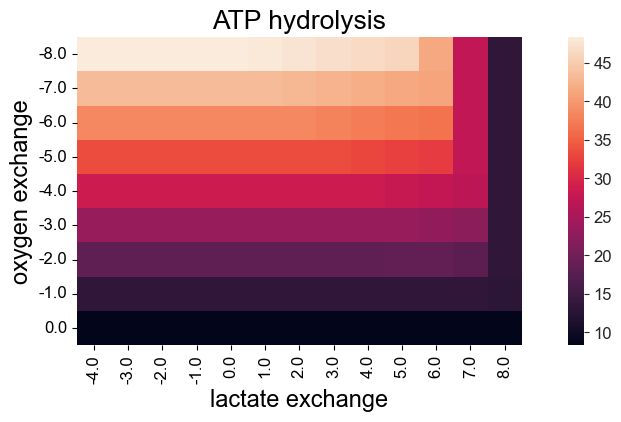

GLUCOSE 0


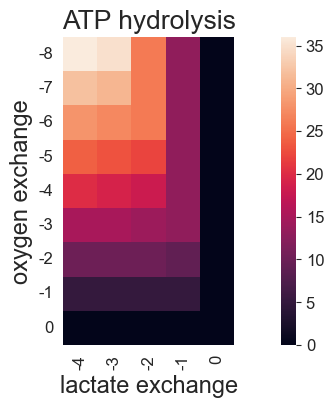

GLUCOSE 1000


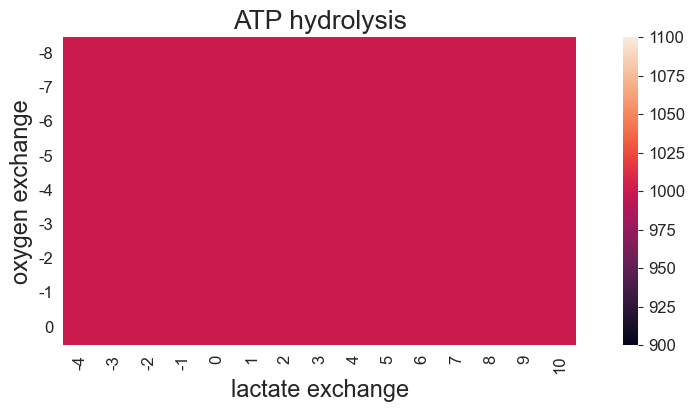

In [11]:
# with models_list[-3]  (mod_RPE_PRrod_Lukowski_singleRPE)

print('oxygen-lactate heatmaps (glucose constant) for mod_RPE_PRrod_Lukowski_singleRPE')

print('GLUCOSE 4.18')
bounds_oxygen = create_stepwise_tuples(-8,1,1)
bounds_lactate = create_stepwise_tuples(-4,10,1)
bounds, labels = create_bounds_and_labels_glucose_constant(bounds_oxygen,bounds_lactate, -4.18)
ovs, fluxes = pre_heatmap_fba(model_list[-3],bounds,labels)
p1 = make_heatmap(ovs)

print('GLUCOSE 0')
bounds_oxygen = create_stepwise_tuples(-8,1,1)
bounds_lactate = create_stepwise_tuples(-4,10,1)
bounds, labels = create_bounds_and_labels_glucose_constant(bounds_oxygen,bounds_lactate, 0)
ovs, fluxes = pre_heatmap_fba(model_list[-3],bounds,labels)
p2 = make_heatmap(ovs)

print('GLUCOSE 1000')
bounds_oxygen = create_stepwise_tuples(-8,1,1)
bounds_lactate = create_stepwise_tuples(-4,10,1)
bounds, labels = create_bounds_and_labels_glucose_constant(bounds_oxygen,bounds_lactate, -1000)
ovs, fluxes = pre_heatmap_fba(model_list[-3],bounds,labels)
p3 = make_heatmap(ovs)

# if not exists already, create folder results/heatmaps/smod_RPE_PRrod_Lukowski_singleRPE
if not os.path.exists('results/heatmaps/mod_RPE_PRrod_Lukowski_singleRPE'):
    os.makedirs('results/heatmaps/mod_RPE_PRrod_Lukowski_singleRPE')

# save figure in results / heatmaps folder
p1.savefig('results/heatmaps/mod_RPE_PRrod_Lukowski_singleRPE/ATP_yield_oxlacsteps_glucose-4.18.png', dpi=300, bbox_inches='tight')
p2.savefig('results/heatmaps/mod_RPE_PRrod_Lukowski_singleRPE/ATP_yield_oxlacsteps_glucose0.png', dpi=300, bbox_inches='tight')
p3.savefig('results/heatmaps/mod_RPE_PRrod_Lukowski_singleRPE/ATP_yield_oxlacsteps_glucose-1000.png', dpi=300, bbox_inches='tight')

In [12]:
model_list[-5]

Name,mod_RPE_PRrod_Lukowski
Memory address,1e1667b1a20
Number of metabolites,10678
Number of reactions,14592
Number of genes,2188
Number of groups,149
Objective expression,1.0*MAR03964_PR - 1.0*MAR03964_PR_reverse_e8402
Compartments,"c_RPE, r_RPE, e_RPE, m_RPE, x_RPE, g_RPE, l_RPE, n_RPE, i_RPE, e_RPE_PR, c_PR, x_PR, m_PR, g_PR, r_PR, l_PR, i_PR"


oxygen-lactate heatmaps (glucose constant) for mod_RPE_PRrod_Lukowski
GLUCOSE 4.18


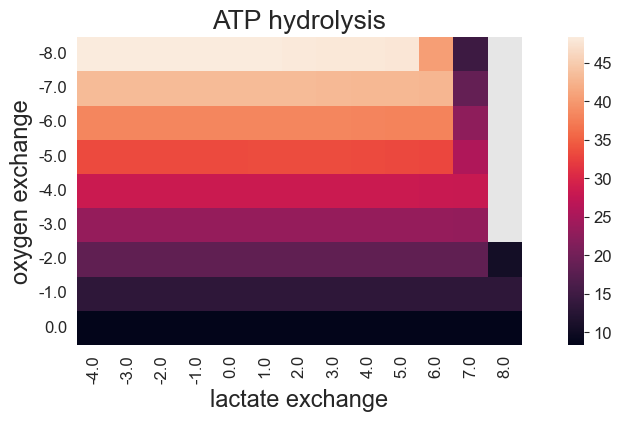

GLUCOSE 0


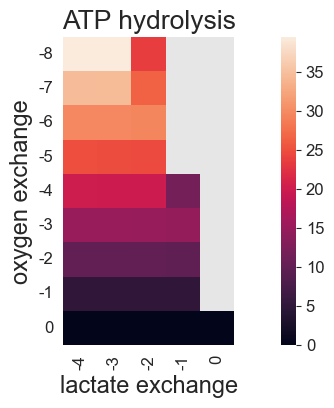

GLUCOSE 1000


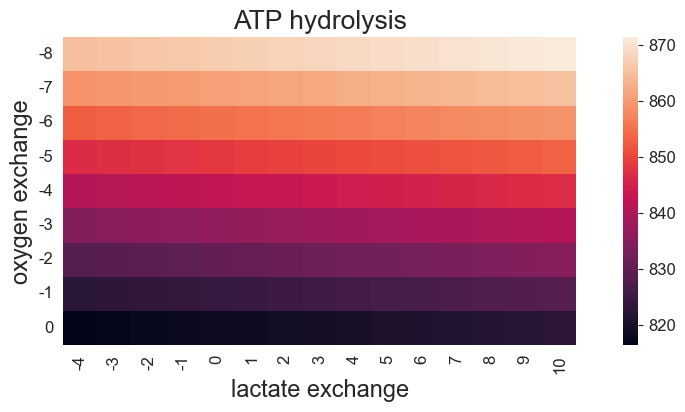

In [13]:
# with models_list[-5]  (RPE-PR model)


print('oxygen-lactate heatmaps (glucose constant) for mod_RPE_PRrod_Lukowski')


print('GLUCOSE 4.18')
bounds_oxygen = create_stepwise_tuples(-8,1,1)
bounds_lactate = create_stepwise_tuples(-4,10,1)
bounds, labels = create_bounds_and_labels_glucose_constant(bounds_oxygen,bounds_lactate, -4.18)
ovs, fluxes = pre_heatmap_fba(model_list[-5],bounds,labels)
p1 = make_heatmap(ovs)

print('GLUCOSE 0')
bounds_oxygen = create_stepwise_tuples(-8,1,1)
bounds_lactate = create_stepwise_tuples(-4,10,1)
bounds, labels = create_bounds_and_labels_glucose_constant(bounds_oxygen,bounds_lactate, 0)
ovs, fluxes = pre_heatmap_fba(model_list[-5],bounds,labels)
p2 = make_heatmap(ovs)

print('GLUCOSE 1000')
bounds_oxygen = create_stepwise_tuples(-8,1,1)
bounds_lactate = create_stepwise_tuples(-4,10,1)
bounds, labels = create_bounds_and_labels_glucose_constant(bounds_oxygen,bounds_lactate, -1000)
ovs, fluxes = pre_heatmap_fba(model_list[-5],bounds,labels)
p3 = make_heatmap(ovs)

# if not exists already, create folder results/heatmaps/smod_RPE_PRrod_Lukowski_singleRPE
if not os.path.exists('results/heatmaps/mod_RPE_PRrod_Lukowski'):
    os.makedirs('results/heatmaps/mod_RPE_PRrod_Lukowski')

# save figure in results / heatmaps folder
p1.savefig('results/heatmaps/mod_RPE_PRrod_Lukowski/ATP_yield_oxlacsteps_glucose-4.18.png', dpi=300, bbox_inches='tight')
p2.savefig('results/heatmaps/mod_RPE_PRrod_Lukowski/ATP_yield_oxlacsteps_glucose0.png', dpi=300, bbox_inches='tight')
p3.savefig('results/heatmaps/mod_RPE_PRrod_Lukowski/ATP_yield_oxlacsteps_glucose-1000.png', dpi=300, bbox_inches='tight')

In [14]:
###############################################################
####### KEEP OXYGEN CONSTANT, VARY GLUCOSE AND LACTATE ########
###############################################################

from src.modify_model import create_permutation_dicts

# create a function to create stepwise tuple lists like the ones above
def create_stepwise_tuples(start,stop,step):
        import numpy as np
        return [(i,i) for i in np.arange(start,stop+step,step)]


# write function to set exchange bounds
def create_bounds_and_labels_oxygen_constant(bounds_glucose, bounds_lactate, oxygen_level):
        ex_bounds = {'MAR09034':bounds_glucose,\
                        'MAR09048': [(oxygen_level,oxygen_level)],\
                        'MAR09135':bounds_lactate}
        ex_labels = {'glucose':bounds_glucose,\
                        'oxygen': [(oxygen_level,oxygen_level)],\
                        'lactate':bounds_lactate}
        bounds = create_permutation_dicts(ex_bounds)
        labels = create_permutation_dicts(ex_labels)
        return bounds,labels


def pre_heatmap_fba2(model,bounds,labels):

    objective_values = []
    fluxes = []
    for i in range(len(bounds)):
        model = set_exchange_bounds(model,bounds[i])
        fba = model.optimize()
        fluxes.append(fba.fluxes)
        objective_values.append(fba.objective_value)

    objective_values_df = pd.DataFrame(objective_values)
    fluxes_df = pd.DataFrame(fluxes)
    objective_values_df['labels'] = labels # add labels

    b_df = pd.DataFrame()
    # create list of b
    for i in range(len(objective_values_df)):
        b = pd.DataFrame(objective_values_df['labels'][i]).iloc[0].to_frame().T
        b_df = pd.concat([b_df,b],axis=0)

    b_df.reset_index(inplace=True,drop=True)
    df = pd.concat([b_df,objective_values_df],axis=1)

    # rename col 0 to objective_value
    df.rename(columns={0:'objective_value'},inplace=True)
    # select columns for heathmap (oxygen, lactate, and objective_value)
    objective_values_and_bounds_df = df[['glucose', 'lactate', 'objective_value']]

    return objective_values_and_bounds_df, fluxes_df

def make_heatmap2(objective_values_and_bounds_df):
    import seaborn as sns
    import matplotlib.pyplot as plt

    df_reshaped = objective_values_and_bounds_df.pivot_table(index='glucose', columns='lactate', values='objective_value')

    fig, ax = plt.subplots(figsize=(12,4))
    # grey background
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    sns.heatmap(df_reshaped, annot=False, fmt='.0f', cmap='rocket', annot_kws={"size": 14})
    plt.title('ATP hydrolysis')
    plt.xlabel('lactate exchange')
    plt.ylabel('glucose exchange')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.tick_params(labelsize=12)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    cbar = ax.collections[0].colorbar
    # size labels cbar
    cbar.ax.tick_params(labelsize=12)
    # size x and y labels
    ax.yaxis.label.set_size(17)
    ax.xaxis.label.set_size(17)
    # title size
    ax.title.set_size(19)
    plt.show()
    return fig


glucose-lactate heatmaps (oxygen constant) for mod_RPE_PRrod_Lukowski
OXYGEN 3.51


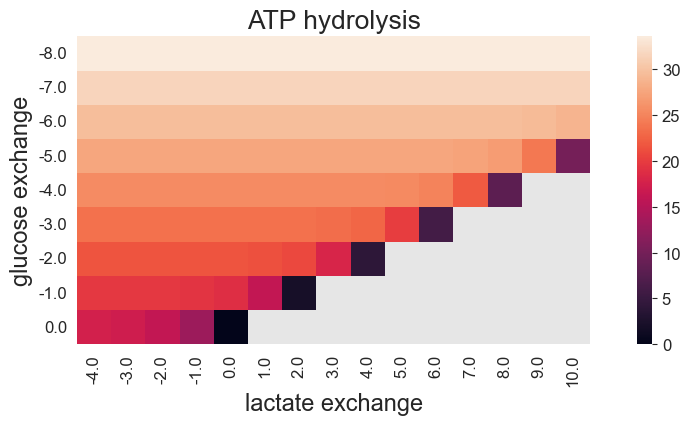

OXYGEN 0


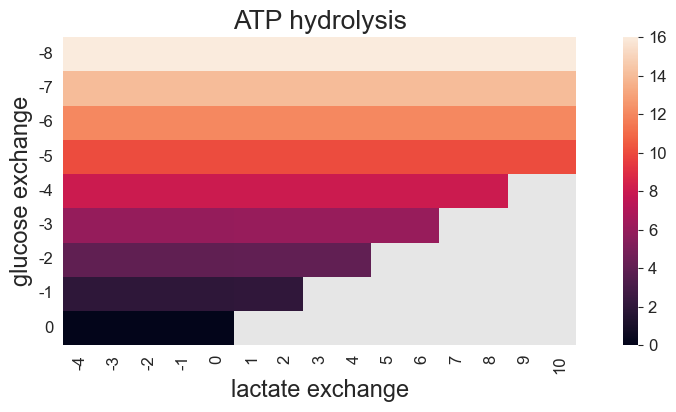

OXYGEN 1000


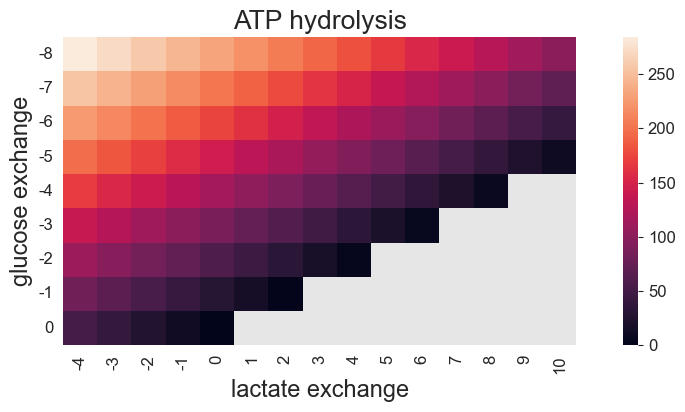

In [15]:
fluxes_RPE_oxygen_constant = {}
ovs_RPE_oxygen_constant = {}

print('glucose-lactate heatmaps (oxygen constant) for mod_RPE_PRrod_Lukowski_singleRPE')

print('OXYGEN 3.51')
bounds_glucose = create_stepwise_tuples(-8,1,1)
bounds_lactate = create_stepwise_tuples(-4,10,1)
bounds, labels = create_bounds_and_labels_oxygen_constant(bounds_glucose,bounds_lactate, -3.51)
ovs, fluxes = pre_heatmap_fba2(model_list[-3],bounds,labels)
fluxes_RPE_oxygen_constant['ox_3.51'] = fluxes
ovs_RPE_oxygen_constant['ox_3.51'] = ovs
p1 = make_heatmap2(ovs)

print('OXYGEN 0')
bounds_glucose = create_stepwise_tuples(-8,1,1)
bounds_lactate = create_stepwise_tuples(-4,10,1)
bounds, labels = create_bounds_and_labels_oxygen_constant(bounds_glucose,bounds_lactate, 0)
ovs, fluxes = pre_heatmap_fba2(model_list[-3],bounds,labels)
fluxes_RPE_oxygen_constant['ox_0'] = fluxes
ovs_RPE_oxygen_constant['ox_0'] = ovs
p2 = make_heatmap2(ovs)


print('OXYGEN 1000')
bounds_glucose = create_stepwise_tuples(-8,1,1)
bounds_lactate = create_stepwise_tuples(-4,10,1)
bounds, labels = create_bounds_and_labels_oxygen_constant(bounds_glucose,bounds_lactate, -1000)
ovs, fluxes = pre_heatmap_fba2(model_list[-3],bounds,labels)
fluxes_RPE_oxygen_constant['ox_-1000'] = fluxes
ovs_RPE_oxygen_constant['ox_-1000'] = ovs
p3 = make_heatmap2(ovs)

# if not exists already, create folder results/heatmaps/smod_RPE_PRrod_Lukowski_singleRPE
if not os.path.exists('results/heatmaps/mod_RPE_PRrod_Lukowski_singleRPE'):
    os.makedirs('results/heatmaps/mod_RPE_PRrod_Lukowski_singleRPE')

# save figure in results / heatmaps folder
p1.savefig('results/heatmaps/mod_RPE_PRrod_Lukowski_singleRPE/ATP_yield_gluclacsteps_ox-3.51.png', dpi=300, bbox_inches='tight')
p2.savefig('results/heatmaps/mod_RPE_PRrod_Lukowski_singleRPE/ATP_yield_gluclacsteps_ox0.png', dpi=300, bbox_inches='tight')
p3.savefig('results/heatmaps/mod_RPE_PRrod_Lukowski_singleRPE/ATP_yield_gluclacsteps_ox-1000.png', dpi=300, bbox_inches='tight')

glucose-lactate heatmaps (oxygen constant) for mod_RPE_PRrod_Lukowski
OXYGEN 3.51


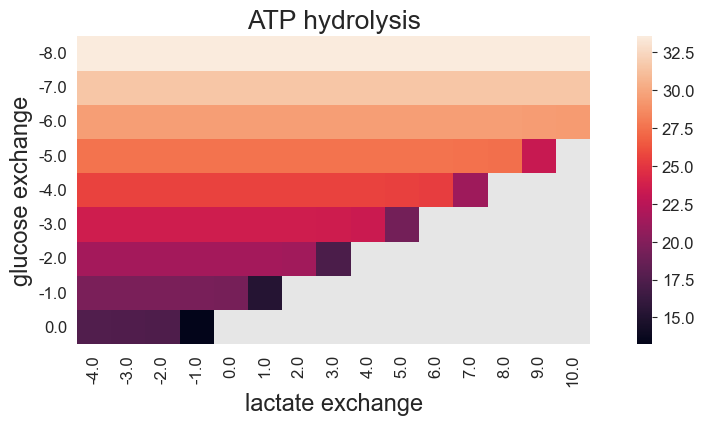

OXYGEN 0


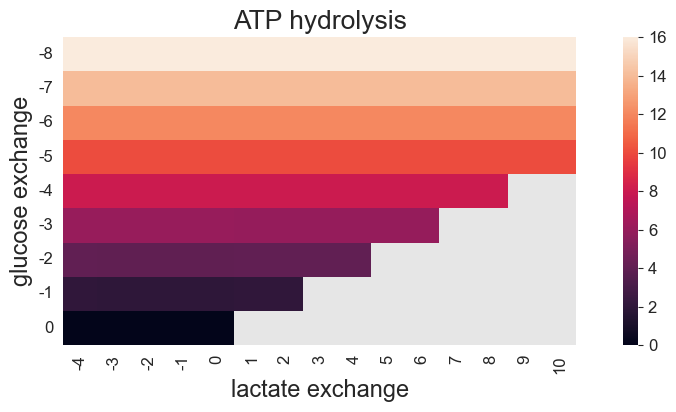

OXYGEN 1000


ValueError: zero-size array to reduction operation fmin which has no identity

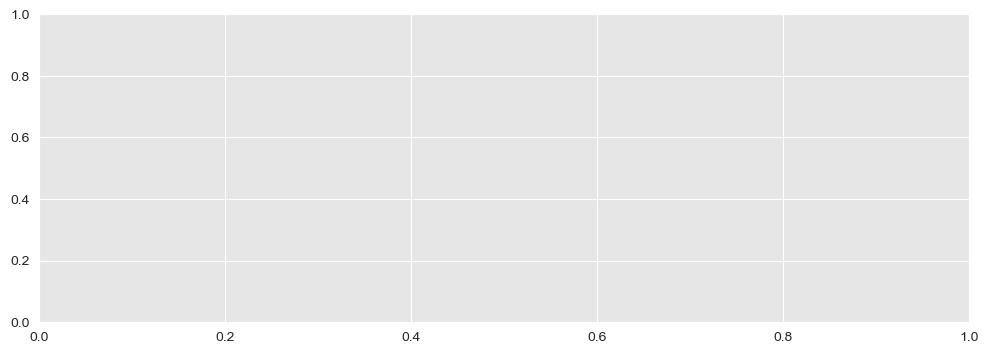

In [20]:
fluxes_RPE_oxygen_constant = {}
ovs_RPE_oxygen_constant = {}

print('glucose-lactate heatmaps (oxygen constant) for mod_RPE_PRrod_Lukowski')

print('OXYGEN 3.51')
bounds_glucose = create_stepwise_tuples(-8,1,1)
bounds_lactate = create_stepwise_tuples(-4,10,1)
bounds, labels = create_bounds_and_labels_oxygen_constant(bounds_glucose,bounds_lactate, -3.51)
ovs, fluxes = pre_heatmap_fba2(model_list[-5],bounds,labels)
fluxes_RPE_oxygen_constant['ox_3.51'] = fluxes
ovs_RPE_oxygen_constant['ox_3.51'] = ovs
p1 = make_heatmap2(ovs)

print('OXYGEN 0')
bounds_glucose = create_stepwise_tuples(-8,1,1)
bounds_lactate = create_stepwise_tuples(-4,10,1)
bounds, labels = create_bounds_and_labels_oxygen_constant(bounds_glucose,bounds_lactate, 0)
ovs, fluxes = pre_heatmap_fba2(model_list[-5],bounds,labels)
fluxes_RPE_oxygen_constant['ox_0'] = fluxes
ovs_RPE_oxygen_constant['ox_0'] = ovs
p2 = make_heatmap2(ovs)


print('OXYGEN 1000')
bounds_glucose = create_stepwise_tuples(-8,1,1)
bounds_lactate = create_stepwise_tuples(-4,10,1)
bounds, labels = create_bounds_and_labels_oxygen_constant(bounds_glucose,bounds_lactate, -1000)
ovs, fluxes = pre_heatmap_fba2(model_list[-5],bounds,labels)
fluxes_RPE_oxygen_constant['ox_-1000'] = fluxes
ovs_RPE_oxygen_constant['ox_-1000'] = ovs
p3 = make_heatmap2(ovs)

# if not exists already, create folder results/heatmaps/smod_RPE_PRrod_Lukowski_singleRPE
if not os.path.exists('results/heatmaps/mod_RPE_PRrod_Lukowski'):
    os.makedirs('results/heatmaps/mod_RPE_PRrod_Lukowski')

# save figure in results / heatmaps folder
p1.savefig('results/heatmaps/mod_RPE_PRrod_Lukowski/ATP_yield_gluclacsteps_ox-3.51.png', dpi=300, bbox_inches='tight')
p2.savefig('results/heatmaps/mod_RPE_PRrod_Lukowski/ATP_yield_gluclacsteps_ox0.png', dpi=300, bbox_inches='tight')
p3.savefig('results/heatmaps/mod_RPE_PRrod_Lukowski/ATP_yield_gluclacsteps_ox-1000.png', dpi=300, bbox_inches='tight')

In [16]:
pd.DataFrame(fluxes_RPE_oxygen_constant['ox_0'])
# make reactions df for model_list[-3]
rxn_df = make_reactions_df(model_list[-3])

,MAR03905_RPE,MAR03907_RPE,MAR04281_RPE,MAR04388_RPE,MAR04283_RPE,MAR08357_RPE,MAR04379_RPE,MAR04301_RPE,MAR04355_RPE,MAR04358_RPE,...,MAR04211_eRPE_PR,MAR08487_eRPE_PR,MAR00001_eRPE_PR,MAR00783_eRPE_PR,MAR04390_eRPE_PR,MAR07663_eRPE_PR,MAR00006_eRPE_PR,MAR02120_eRPE_PR,MAR02186_eRPE_PR,MAR12050_eRPE_PR
fluxes,0.0,0.0,0.000000,16.000000,0.0,0.0,8.0,0.000000,0.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fluxes,0.0,0.0,0.000000,16.000000,0.0,0.0,8.0,0.000000,0.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fluxes,0.0,0.0,0.000000,16.000000,0.0,0.0,8.0,0.000000,0.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fluxes,0.0,0.0,0.000000,16.000000,0.0,0.0,8.0,0.000000,0.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fluxes,0.0,0.0,0.000000,16.000000,0.0,0.0,8.0,0.000000,0.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fluxes,0.0,0.0,-0.047507,-2.046512,0.0,0.0,0.0,0.838398,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fluxes,0.0,0.0,0.000000,13.840754,0.0,0.0,0.0,32.063644,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fluxes,0.0,0.0,0.000000,56.003425,0.0,0.0,0.0,4.557030,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fluxes,0.0,0.0,0.000000,9.000000,0.0,0.0,0.0,4.500000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# NO SOLUTIONS


# ############### 1000 GLUCOSE  ###############

# # write function to do analysis for heatmaps
# bounds_oxygen = create_stepwise_tuples(-8,1,0.5)
# bounds_lactate = create_stepwise_tuples(-4,10,0.5)
# ex_bounds = {'MAR09048':[(-1000,-1000)],\
#         'MAR09034':bounds_oxygen,\
#         'MAR09135':bounds_lactate}

# ex_labels = {'glucose':[(-1000,-1000)],\
#         'oxygen':bounds_oxygen,\
#         'lactate':bounds_lactate}

# bounds = create_permutation_dicts(ex_bounds)
# labels = create_permutation_dicts(ex_labels)

# RPE_PR_fluxes_1000glucose , RPE_PR_ovs_1000glucose = make_heatmap(model,bounds,labels)